In [5]:
import math
import os
import re
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def getData(lens_mode, gps_type):
    files = list(map(
        lambda x: 'lens_%s.dir/%s' % (lens_mode, x),
        list(filter(
            lambda x: x[:2] == gps_type,
            os.listdir('./lens_%s.dir' % lens_mode)))
    ))
    
    le = []
    ln = []
    
    for file in files:
        with open(file, 'r') as f:
            data = f.read()
            data = '\n'.join(data.replace(' ', '').replace('#', '').split('\n')[3:])
        sio = StringIO(data)
        df = pd.read_csv(sio, names=['iZ', '_', '__', 'dE', 'dE^2', 'N'])
        le.append(df['dE'].values)
        ln.append(df['N'].values)
#         df = df.drop(columns=['_', '__'])
        
#     print(data)
    return np.array(le), np.array(ln)


def processData(data):
    l = []
    # MeV to joule
    c = 1.6 * 10**-19 * 10**6
    for i in range(len(data[0])):
        dE = (data[:,i] * c).mean()
        sigma = (data[:,i] * c).std()
        gamma = sigma / dE
        l.append({
            'z': 4.5 + 0.5 * i,
            'dE': dE,
            'sigma': sigma,
            'gamma': gamma})
        
    df = pd.DataFrame(l)
    
    h = 0.5
    r = 2.45
    pi = 3.1415926535

    V0 = h * pi * r**2

    df['m'] = 0
    for i in range(len(df) - 4):
        df['m'].iloc[i] = V0

    r2 = 2.45
    for i in range(len(df) - 4, len(df)):
        r1 = r2 - h * 0.5
        V = 1 / 3 * pi * h * (r1**2 + r2**2 + r1*r2)
        df['m'].iloc[i] = V
        r2 = r1

    df['D'] = df['dE'] / df['m']

    return df

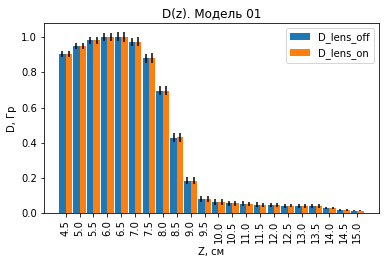

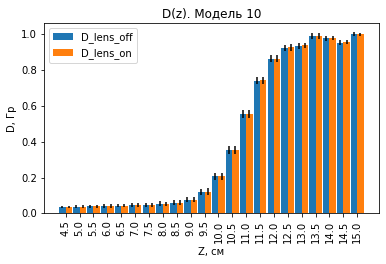

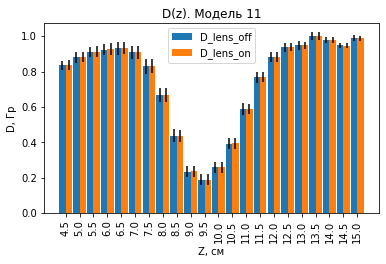

In [43]:
for model in ['01', '10', '11']:
    q0, w0 = getData('off', model)
    q1, w1 = getData('on', model)

    df0 = processData(q0)
    df1 = processData(q1)

    fig, ax = plt.subplots(figsize=(6, 3.5))
    # plt.yscale("log")

    x = df0['z']
    y0 = df0['D'] / df0['D'].max()
    y1 = df1['D'] / df1['D'].max()

    err0 = df0['sigma'] / df0['m'] / df0['D'].max()
    err1 = df1['sigma'] / df1['m'] / df1['D'].max()

    width = 0.23  # the width of the bars

    rects0 = ax.bar(x - width/2, y0, width, yerr=err0,
                    label='D_lens_off')

    rects1 = ax.bar(x + width/2, y1, width, yerr=err1,
                    label='D_lens_on')

    ax.set_ylabel('D, Гр')
    ax.set_xlabel('Z, см')
    ax.set_title('D(z). Модель %s' % model)
    ax.set_xticks(x)
    ax.set_xticklabels(x, rotation='vertical')
    ax.legend()   

    plt.draw()

    fig.savefig('D(z). Модель %s.jpeg' % model, dpi=fig.dpi)

    data_to_save = pd.DataFrame()
    data_to_save['z'] = df0['z']
    data_to_save['D_lens_off'] = df0['D']
    data_to_save['D_lens_on'] = df1['D']

    data_to_save['sigma_lens_off'] = df0['sigma']
    data_to_save['sigma_lens_on'] = df1['sigma']

    data_to_save.to_excel('Данные модели %s.xlsx' % model)

In [16]:
q0[0] / q0[0].max()

array([0.89141744, 0.9394047 , 0.96485874, 0.98345269, 0.98589257,
       0.96863778, 0.88911321, 0.70711254, 0.47257502, 0.2623417 ,
       0.1968231 , 0.27364842, 0.42962837, 0.62888345, 0.82405057,
       0.93111303, 0.99258517, 1.        , 0.95957063, 0.74854428,
       0.5591619 , 0.43587708])

In [38]:
def getData(lens_mode, gps_type):
    files = list(map(
        lambda x: 'lens_%s.dir/%s' % (lens_mode, x),
        list(filter(
            lambda x: x[:2] == gps_type,
            os.listdir('./lens_%s.dir' % lens_mode)))
    ))
    
    le = []
    ln = []
    
    for file in files:
        with open(file, 'r') as f:
            data = f.read()
            data = '\n'.join(data.replace(' ', '').replace('#', '').split('\n')[3:])
        sio = StringIO(data)
        df = pd.read_csv(sio, names=['iZ', '_', '__', 'dE', 'dE^2', 'N'])
        le.append(df['dE'].values)
        ln.append(df['N'].values)
#         df = df.drop(columns=['_', '__'])
        
#     print(data)
    return np.array(le), np.array(ln)

def getM(q):
    h = 0.5
    r = 2.45
    pi = 3.1415926535

    V0 = h * pi * r**2

    m = []
    for i in range(len(q[0])):
        m.append(V0)

    r2 = 2.45
    for i in range(len(q[0]) - 4, len(q[0])):
        r1 = r2 - h * 0.5
        V = 1 / 3 * pi * h * (r1**2 + r2**2 + r1*r2)
        m[i] = V
        r2 = r1

    m = np.array(m)
    return m

def getZ(q):
    h = 0.5
    l = np.zeros(len(q[0]))
    for i in range(len(l)):
        l[i] = i * h
        
    l += 4.5
    return l

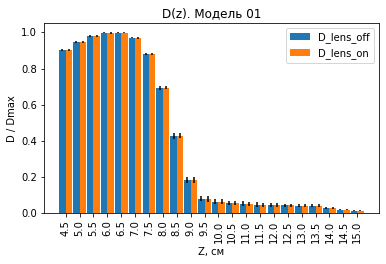

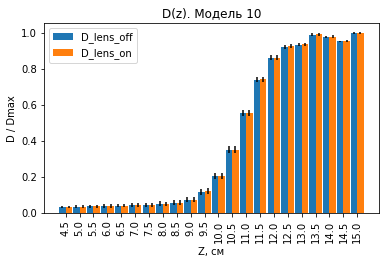

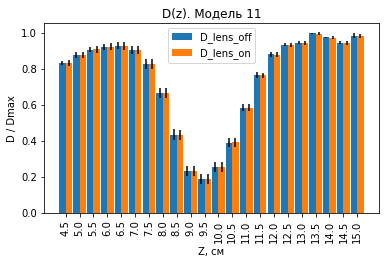

In [60]:
for model in ['01', '10', '11']:
    q0, w0 = getData('off', model)
    q1, w1 = getData('on', model)

    q0 /= getM(q0)
    q1 /= getM(q1)

    for i in range(len(q)):
        q0[i] /= q0[i].max()
        q1[i] /= q1[i].max()


    q0_mean = q0.mean(axis=0)
    q1_mean = q1.mean(axis=0)

    q0_std = q0.std(axis=0)
    q1_std = q1.std(axis=0)

    df0 = pd.DataFrame(columns=['z', 'D / D_max'])
    df1 = pd.DataFrame(columns=['z', 'D / D_max'])

    df0['z'] = getZ(q0)
    df1['z'] = getZ(q1)

    df0['D / D_max'] = q0_mean
    df1['D / D_max'] = q1_mean

    df0['sigma'] = q0_std
    df1['sigma'] = q1_std


    fig, ax = plt.subplots(figsize=(6, 3.5))

    x = df0['z']
    y0 = df0['D / D_max']
    y1 = df1['D / D_max']

    err0 = df0['sigma']
    err1 = df1['sigma']

    width = 0.23  # the width of the bars

    rects0 = ax.bar(x - width/2, y0, width, yerr=err0,
                    label='D_lens_off')

    rects1 = ax.bar(x + width/2, y1, width, yerr=err1,
                    label='D_lens_on')

    ax.set_ylabel('D / Dmax')
    ax.set_xlabel('Z, см')
    ax.set_title('D(z). Модель %s' % model)
    ax.set_xticks(x)
    ax.set_xticklabels(x, rotation='vertical')
    ax.legend()   

    plt.draw()

    fig.savefig('Dn(z). Модель %s.jpeg' % model, dpi=fig.dpi)

    data_to_save = pd.DataFrame()
    data_to_save['z'] = df0['z']
    data_to_save['D / D_max (lens_off)'] = df0['D / D_max']
    data_to_save['D / D_max (lens_on)'] = df1['D / D_max']

    data_to_save['sigma_lens_off'] = df0['sigma']
    data_to_save['sigma_lens_on'] = df1['sigma']

    data_to_save.to_excel('Данные модели %s.xlsx' % model)


In [63]:
df0['D / D_max'].max() / df0['D / D_max'].min()

5.246416692658976